In [1]:
#import importlib
#import reaction as rxn
#importlib.reload(rxn)

In [5]:
from  random import randint 
import numpy as np
from scipy.integrate import solve_ivp as solver
from sympy import Symbol,init_printing,Eq,Add,pprint as sympprint
from massplotter import mass_plot as mplot
init_printing()

class RXN():
    class Reagent():
        def __init__(self,mw,name="Reagent"+str(randint(1,10**6)),c0=0):
            self.mw = mw
            self.name = name
            self.c0 = c0

        def __str__(self):
            return self.name
        __repr__ = __str__


    class Reaction():
        def __init__(self,educts,products,name="Reaction"+str(randint(1,10**6)),k1=1,k2=0,rxnfunc=None):
            self.educts=educts
            self.products = products
            self.k2=k2
            self.k1=k1
            self.name = name
            if rxnfunc is None:
                rxnfunc = self._default_rxnfunc
            self.rxnfunc=rxnfunc

        def _default_rxnfunc(self,particles,is_nan_array=None,first_nans=None,randoms=None):
            if is_nan_array is None:
                is_nan_array=np.isnan(particles) 
                first_nans = np.argmax(is_nan_array,1)
            if first_nans is None:    
                first_nans = np.argmax(is_nan_array,1) 

            for n,r in self.educts:
                if n > 0:
                    fnp=first_nans[r.position]
                    if (fnp-n)<0:
                        return is_nan_array,first_nans, randoms
                    particles[r.position][fnp-n:fnp]=np.nan
                    is_nan_array[r.position][fnp-n:fnp]=True
                    first_nans[r.position] -= n

            for n,r in self.products:
                if n > 0:
                    fnp=first_nans[r.position]
                    particles[r.position][fnp:fnp+n]=r.mw
                    is_nan_array[r.position][fnp:fnp+n]=False
                    first_nans[r.position] += n

            return is_nan_array,first_nans,randoms


        def reaction_string(self):
            s= " + ".join([(str(n)+" " if n > 1 else "")+(r.name)  for n,r in self.educts]) +\
            " "+("<" if self.k2 > 0 else "") +"--> " +\
            " + ".join([(str(n)+" " if n > 1 else "")+(r.name)  for n,r in self.products]) +\
             " ("+str(self.k1) + (","+str(self.k2) if self.k2>0 else "")+")"
            return s

        def __str__(self):
            return self.name


        def get_diff_functions_str(self,k_as_number=False):
            eqs={}
            for n,r in self.educts:
                f =  -n*(self.k1 if k_as_number else Symbol("k_1"+self.name))
                for ns,rs in self.educts:
                    f=f*Symbol("["+str(rs)+"]")**ns
                eqs[r] =  eqs.get(r,[])+[f]

                f =  n*(self.k2 if k_as_number else Symbol("k_2"+self.name))
                for ns,rs in self.products:
                    f=f*Symbol("["+str(rs)+"]")**ns
                eqs[r] =  eqs.get(r,[])+[f]

            for n,r in self.products:
                f =  n*(self.k1 if k_as_number else Symbol("k_1"+self.name))
                for ns,rs in self.educts:
                    f=f*Symbol("["+str(rs)+"]")**ns
                eqs[r] =  eqs.get(r,[])+[f]

                f = -n*(self.k2 if k_as_number else Symbol("k_2"+self.name))
                for ns,rs in self.products:
                    f=f*Symbol("["+str(rs)+"]")**ns
                eqs[r] =  eqs.get(r,[])+[f]

            return eqs

        def _create_sub_diff(self,n,r,ed=True):
            fac1 = n*self.k1
            fac2 = -n*self.k2
            if ed:
                fac1 = - fac1
                fac2 = - fac2

            def f(cs,react_dic):
                    b1 = b2 = 0
                    if fac1 != 0:
                        b1 =  fac1
                        for ns,rs in self.educts:
                            b1 =b1 * cs[react_dic[rs]]**ns
                    if fac2 != 0:
                        b2 =  fac2
                        for ns,rs in self.products:
                            b2 =b2 * cs[react_dic[rs]]**ns
                    return b1+b2

            return f

        def get_diff_functions(self):
            eqs={}
            for n,r in self.educts:
                f = self._create_sub_diff(n,r,True)
                eqs[r] =  eqs.get(r,[])+[f]

            for n,r in self.products:
                f = self._create_sub_diff(n,r,False)
                eqs[r] =  eqs.get(r,[])+[f]

            return eqs

        def get_rate(self,reacts):
            rate1=self.k1
            if rate1 != 0:
                for n,r in self.educts:
                    rate1=rate1*reacts[r]**n

            rate2 = self.k2
            if rate2 != 0:
                for n,r in self.products:
                    rate2=rate2*reacts[r]**n

            return np.array([rate1,rate2])

    class ReactionSet():
        def __init__(self,reactions):
            self.reactions = reactions
            self.prepared = False
            self.reacts_ord={}
            self.reacts = []
            self.c0s = []
            self.diff_eq = []
            self.diff_eq_str = []
            self.kinetic_solve = None

        def print_diff_equations(self,k_as_number=False):
            deqs={}
            r:Reaction
            for r in self.reactions:
                for reagent,subequations in r.get_diff_functions_str(k_as_number=k_as_number).items():
                    deqs[reagent] = deqs.get(reagent,[]) + subequations

            dt_sym = Symbol("dt")
            for reac,eqs in deqs.items():
                e=Eq(Symbol("d["+str(reac)+"]")/dt_sym,Add(*eqs))
                try:
                    display(e)
                except:
                    sympprint(e)




        def __str__(self):
            return "\n".join([str(reaction)+": "+reaction.reaction_string() for reaction in self.reactions])


        def prepare(self):
            self.reacts_ord={}
            for rxn in self.reactions:
                for n,reac in (rxn.educts + rxn.products):
                    if reac not in self.reacts_ord:
                        self.reacts_ord[reac] = len(self.reacts_ord)
            self.reacts = [None for i in self.reacts_ord]

            for r,p in self.reacts_ord.items():
                self.reacts[p]=r

            self.c0s = [r.c0 for r in self.reacts]

            self.diff_eq = [[] for r in self.reacts]
            self.rxn_functions = []
            self.diff_eq_str = [[] for r in self.reacts]

            for rxn in self.reactions:
                self.rxn_functions.append(rxn.rxnfunc)
                for reac,funcs in rxn.get_diff_functions().items():
                    self.diff_eq[self.reacts_ord[reac]].extend(funcs)
                for reac,funcs in rxn.get_diff_functions_str().items():
                    self.diff_eq_str[self.reacts_ord[reac]].extend(funcs)
            self.prepared=True

        def solve_kinetics(self,time=10,min_resolution=np.inf):
            if self.prepared==False:
                self.prepare()
            self.tp = 0
            def da(t,c):
                self.tp=t
                rates=[0 for i in self.reacts]
                for i in range(len(self.reacts)):
                    rates[i] = rates[i] + sum([eq(c,self.reacts_ord) for eq in self.diff_eq[i]]) 
                return rates
            self.kinetic_solve = solver(da,(0,time),self.c0s,max_step=min_resolution)
            return self.kinetic_solve

        def plot_kinetics(self,add_normed=False):
            if self.kinetic_solve is None:
                self.solve_kinetics()
            mplot(self.kinetic_solve.t,self.kinetic_solve.y, title="kinetic",labels=self.reacts)
            if add_normed:
                mplot(self.kinetic_solve.t,self.kinetic_solve.y, title="kinetic normed",norm=True,labels=self.reacts)
rxn=RXN()

In [6]:
#Reagents
ini = rxn.Reagent(160,"Ini",1)
inirad = rxn.Reagent(ini.mw/2,ini.name+"*",0)
mono = rxn.Reagent(100.12,"M",100)

poly = rxn.Reagent(0,"P",0)
polyrad = rxn.Reagent(poly.mw,poly.name+"*",0)

In [3]:
#Reactions
from  functools import partial
import random

def growfunc(particles,ed1,ed2,pd1,is_nan_array=None,first_nans=None,randoms=None):
    
    if is_nan_array is None:
        is_nan_array=np.isnan(particles) 
        first_nans = np.argmax(is_nan_array,1)
    if first_nans is None:    
        first_nans = np.argmax(is_nan_array,1) 
        
    if randoms is None or randoms.size<10:
        randoms = np.random.rand(10**4)
    first_nan_1=first_nans[ed1.position]#
    
    
    if first_nan_1 == 0:
        if is_nan_array[ed1.position][-1]:
            return is_nan_array,first_nans,randoms
        first_nan_1 = is_nan_array.shape[1]
        
    ran,randoms=randoms[-1],randoms[:-1]
    i1 = int(first_nan_1 * ran)
    particles[ed1.position][i1],particles[ed1.position][first_nan_1-1] = particles[ed1.position][first_nan_1-1],particles[ed1.position][i1]
    mw1 = particles[ed1.position][first_nan_1-1]
    
    particles[ed1.position][first_nan_1-1] = np.nan
    is_nan_array[ed1.position][first_nan_1-1] = True
    first_nans[ed1.position] -= 1 #
    
    first_nan_2=first_nans[ed2.position]#
    
    if first_nan_2 == 0:
        if is_nan_array[ed2.position][-1]:
            particles[ed1.position][first_nan_1-1] = mw1
            is_nan_array[ed1.position][first_nan_1-1]=False
            first_nans[ed1.position] += 1
            return is_nan_array,first_nans,randoms
        first_nan_2 = is_nan_array.shape[1]
        
    ran,randoms=randoms[-1],randoms[:-1]
    i2 = int(first_nan_2 * ran)
    particles[ed2.position][i2],particles[ed2.position][first_nan_2-1] = particles[ed2.position][first_nan_2-1],particles[ed2.position][i2]
    mw2 = particles[ed2.position][first_nan_2-1]
    
    particles[ed2.position][first_nan_2-1] = np.nan
    is_nan_array[ed2.position][first_nan_2-1] = True
    first_nans[ed2.position] -= 1
    
    first_nan_3=first_nans[pd1.position]
    
    particles[pd1.position][first_nan_3] = mw1+mw2
    is_nan_array[pd1.position][first_nan_3] = False
    first_nans[pd1.position] += 1
    
    return is_nan_array,first_nans,randoms
    

ini_deg = rxn.Reaction([(1,ini)],[(2,inirad)],k1=1,k2=0.5,name="inideg")
initiation = rxn.Reaction([(1,inirad),(1,mono)],[(1,polyrad)],k1=0.8,name="ini",rxnfunc=partial(growfunc,ed1=inirad,ed2=mono,pd1=polyrad))
grow = rxn.Reaction([(1,polyrad),(1,mono)],[(1,polyrad),],k1=0.5,name="grow",rxnfunc=partial(growfunc,ed1=polyrad,ed2=mono,pd1=polyrad))
exit1= rxn.Reaction([(2,polyrad)],[(1,poly)],k1=0.2,name="ex1",rxnfunc=partial(growfunc,ed1=polyrad,ed2=polyrad,pd1=poly))
exit2= rxn.Reaction([(1,polyrad),(1,inirad)],[(1,poly)],name="ex2",k1=0.2,rxnfunc=partial(growfunc,ed1=polyrad,ed2=inirad,pd1=polyrad))


In [256]:
#create reaction set
polymerization = rxn.ReactionSet([ini_deg,initiation,grow,exit1,exit2])
print(polymerization)

inideg: Ini <--> 2 Ini* (1,0.5)
ini: Ini* + M --> P* (0.8)
grow: P* + M --> P* (0.5)
ex1: 2 P* --> P (0.2)
ex2: P* + Ini* --> P (0.2)


In [257]:
#get diff equations
polymerization.print_diff_equations(k_as_number=True)

In [258]:
#solve kinetics
e = polymerization.solve_kinetics(time=20,min_resolution=0.01)

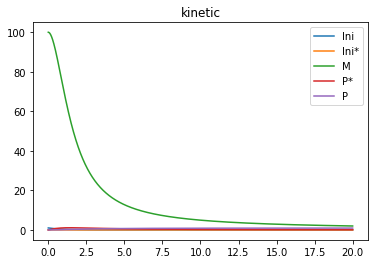

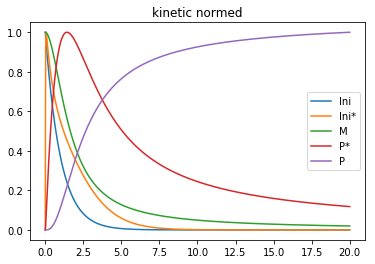

In [259]:
#plotted kinetics
polymerization.plot_kinetics(add_normed=True)

In [260]:
from massplotter import mass_plot as plot
import numpy as np

C:\Users\Julian Stobbe\AppData\Local\conda\conda\envs\chemistry\lib\site-packages\ipykernel_launcher.py:51: UserWarning: invalid data, chooose: rates, 


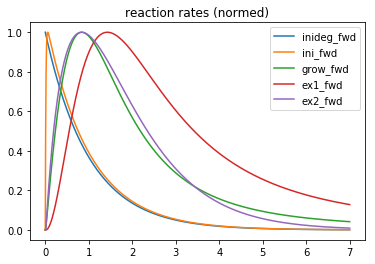

In [302]:
import warnings
def get_mass_distribution(ppC=10**5):
    if polymerization.kinetic_solve is None:
        polymerization.solve_kinetics()
        
    polymerization.diff_t = np.diff(polymerization.kinetic_solve.t)
    
    rxncounts=np.zeros((len(polymerization.kinetic_solve.t),len(polymerization.reactions),2))
    rxnrates=np.zeros((len(polymerization.kinetic_solve.t),len(polymerization.reactions),2))

    for i in range(len(polymerization.kinetic_solve.y[0])-1):
        reacts=dict(zip(polymerization.reacts, polymerization.kinetic_solve.y[0:,i]))
        rxnrates[i]=np.concatenate([r.get_rate(reacts) for r in polymerization.reactions]).reshape(-1,2)
        rxncounts[i]=rxnrates[i]*polymerization.diff_t[i]*ppM

    rxncounts=rxncounts.transpose(1, 0, 2)
    rxnrates=rxnrates.transpose(1, 0, 2)
    
    for c in rxncounts:
        c[:-1]=c[:-1]+np.diff(c,axis=0)/2
    rxncounts = rxncounts.astype(int)
    
    polymerization.rxncounts=rxncounts
    polymerization.rxnrates=rxnrates
    

def plot_data(data="rates",normed=False,fw=True,bw=True,start=-np.inf,end=np.inf,title=None,lables=None):
    if polymerization.kinetic_solve is None:
            polymerization.solve_kinetics()
            
    if polymerization.kinetic_solve.t[0]>=start:
            index_start = 0
    else:
        index_start=np.argmax(polymerization.kinetic_solve.t>=start)
        
    if polymerization.kinetic_solve.t[-1]<end:
        index_end = len(polymerization.kinetic_solve.t)
    else:
        index_end=np.argmax(polymerization.kinetic_solve.t>end)

    data_array=None
    if data=="rates":
        if fw and bw:
            data_array = np.append(polymerization.rxnrates[:,index_start:index_end,0],polymerization.rxnrates[:,index_start:index_end,1]).reshape(polymerization.rxnrates[:,index_start:index_end,:].shape[0]*2,polymerization.rxnrates[:,index_start:index_end,:].shape[1])
        elif fw:
            data_array = polymerization.rxnrates[:,index_start:index_end,0]
        elif bw: 
            data_array = polymerization.rxnrates[:,index_start:index_end,1]
        if title is None:
            title = "reaction rates"+(" (normed)" if normed else "")
        if lables is None:
            lables = ([str(r)+"_fwd" for r in polymerization.reactions] if fw else [])+([str(r)+"_bwd" for r in polymerization.reactions] if bw else [])
    if data=="kinetics":
        data_array=self.kinetic_solve.y
    q<
        else:
            warnings.warn("invalid data, chooose: "+"rates, kinetics")
            return
    if data_array is None:
        warnings.warn("no data")
        return
    
    plot(polymerization.kinetic_solve.t[index_start:index_end],data_array, title=title,norm=normed,labels=lables)

            
    
get_mass_distribution()
plot_data(data="kinetics",end=7,normed=True,bw=False)
plot_data(data="rates",end=7,normed=True,bw=False)

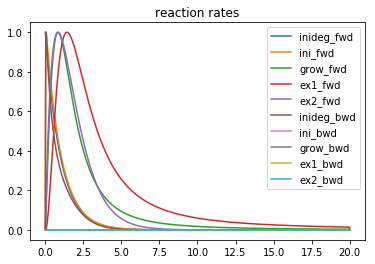

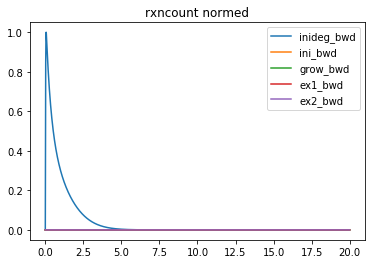

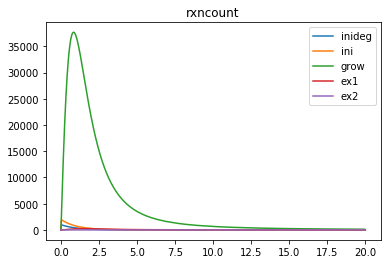

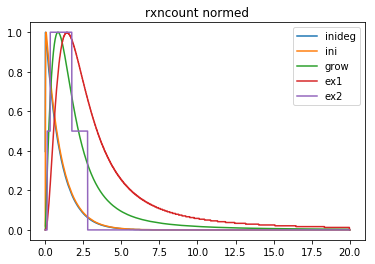

In [262]:
plot(polymerization.kinetic_solve.t,np.append(rxnrates.transpose(1,0,2)[:,:,0],rxnrates.transpose(1,0,2)[:,:,1]).reshape(rxnrates.transpose(1,0,2).shape[0],-1), title="reaction rates",norm=True,labels=[str(r)+"_fwd" for r in polymerization.reactions]+[str(r)+"_bwd" for r in polymerization.reactions])
plot(polymerization.kinetic_solve.t,rxnrates.transpose(1,0,2)[:,:,1], title="rxncount normed",norm=True,labels=[str(r)+"_bwd" for r in polymerization.reactions])
plot(polymerization.kinetic_solve.t,rxncounts[:,:,0], title="rxncount",labels=polymerization.reactions)
plot(polymerization.kinetic_solve.t,rxncounts[:,:,0], title="rxncount normed",norm=True,labels=polymerization.reactions)


In [188]:

%load_ext line_profiler
def toprof():
    print(1)
%lprun -f print toprof()

Timer unit: 5.14057e-07 s

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
1


In [189]:
maxc=max(*[r.c0 for r in polymerization.reacts])
for i in range(len(polymerization.reacts)):
    polymerization.reacts[i].position = i

particles=np.empty((len(polymerization.reacts),int(maxc*ppM*1.01))) * np.nan
for react in polymerization.reacts:
    particles[react.position][0:react.c0*ppM] = react.mw
trxn = rxncounts.transpose(1,0,2)
isnan = None 
first_nans = None
rxnrates.transpose(1,0,2)[:,:,0]+rxnrates.transpose(1,0,2)[:,:,1]randoms = None
pcount=np.zeros((trxn.shape[0],trxn.shape[1]))

for timepoint in range(trxn.shape[0]):
    for reactionpoint in range(trxn.shape[1]):
        reaction = polymerization.reactions[reactionpoint]
        for t in range(trxn[timepoint][reactionpoint][0]):
                isnan,first_nans,randoms = reaction.rxnfunc(particles,is_nan_array=isnan,first_nans=first_nans,randoms=randoms)
    
        pcount[timepoint] = first_nans

In [190]:
particles

array([[     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [   80.  ,    80.  ,    80.  , ...,      nan,      nan,      nan],
       [  100.12,   100.12,   100.12, ...,      nan,      nan,      nan],
       [ 7589.  ,  8590.2 , 11193.32, ...,      nan,      nan,      nan],
       [  560.48,   660.6 ,   660.6 , ...,      nan,      nan,      nan]])

In [191]:
pcount

array([[9.961200e+04, 7.380000e+02, 9.999962e+06, 3.800000e+01,
        0.000000e+00],
       [9.878800e+04, 1.910000e+03, 9.999392e+06, 5.140000e+02,
        0.000000e+00],
       [9.782600e+04, 2.656000e+03, 9.997728e+06, 1.692000e+03,
        0.000000e+00],
       ...,
       [0.000000e+00, 6.440000e+02, 1.999100e+05, 1.522400e+04,
        9.186200e+04],
       [0.000000e+00, 6.440000e+02, 1.998930e+05, 1.522400e+04,
        9.186200e+04],
       [0.000000e+00, 6.440000e+02, 1.998930e+05, 1.522400e+04,
        9.186200e+04]])

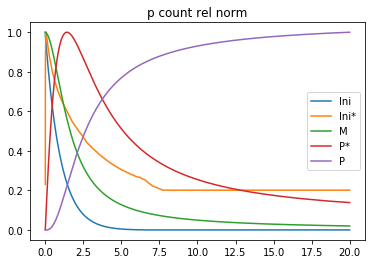

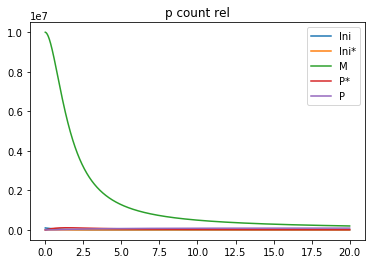

In [192]:
from massplotter import mass_plot as plot
plot(polymerization.kinetic_solve.t,pcount.transpose(), title="p count rel norm",norm=True,labels=polymerization.reacts)
plot(polymerization.kinetic_solve.t,pcount.transpose(), title="p count rel",labels=polymerization.reacts)


11979 9289 1.2895393752523643


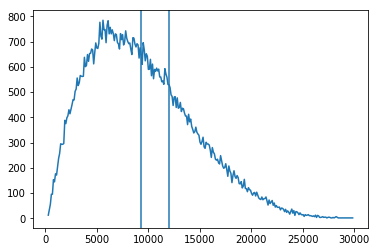

In [197]:
reac=poly
res=mono.mw
a=(np.sort(particles[reac.position][~np.isnan(particles[reac.position])])/res).astype(int)*res
unique, counts = np.unique(a, return_counts=True)

mn=sum(unique*counts)/sum(counts)
mw=sum(unique*counts*unique)/sum(unique*counts)
d=mw/mn
print(int(mw),int(mn),d)

plt.plot(unique[:],counts[:])
plt.axvline(x=mn)
plt.axvline(x=mw)
plt.show()

Ini
Ini*
M
P*
P
inideg
ini
grow
ex1
ex2
[[-1.  0.  0.  0.  0.]
 [ 2. -1.  0.  0. -1.]
 [ 0. -1. -1.  0.  0.]
 [ 0.  1.  0. -2. -1.]
 [ 0.  0.  0.  1.  1.]]
-1.0 0.0 0.0 0.0 0.0 -0.9996467082126997
2.0 -1.0 0.0 0.0 -1.0 1.94381724940738
0.0 -1.0 -1.0 0.0 0.0 -0.05613273330022758
0.0 1.0 0.0 -2.0 -1.0 0.05547616145645896
0.0 0.0 0.0 1.0 1.0 2.7807301245322122e-09


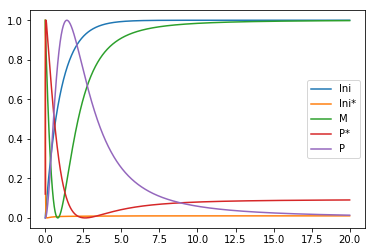

In [184]:
rates = np.zeros(len(polymerization.reactions),np.float)
d = np.array([differentiate(e.t,e.y[i]) for i in range(len(e.y))])
for i in range(len(d)):
    plt.plot(e.t,(d[i]-d[i].min())/(d[i]-d[i].min()).max(),label=str(polymerization.reacts[i]))
plt.legend()
#print(d)
diffarray = np.zeros((len(polymerization.reactions),len(polymerization.reacts)))
for r in polymerization.reacts:
    print(r)
for i in range(len(polymerization.reactions)):
    for n, reac in polymerization.reactions[i].educts:
        diffarray[i][polymerization.reacts_ord[reac]] = diffarray[i][polymerization.reacts_ord[reac]] - n
    for n, reac in polymerization.reactions[i].products:
        diffarray[i][polymerization.reacts_ord[reac]] = diffarray[i][polymerization.reacts_ord[reac]] + n
    
    print(polymerization.reactions[i])
print(diffarray.transpose())
    #n1*r1...ni*ri= d reac i

for i in range(len(diffarray.transpose())):
    print(" ".join([str(diffarray.transpose()[i][j]) for j in range(len(diffarray.transpose()[i]))]) + " "+str(d[0:,0][i]))

    

In [274]:
a=rxnrates[:,:,0]
b=rxnrates[:,:,1]
c=np.append(a,b).reshape(rxnrates.shape[0]*2,rxnrates.shape[1])
print(c)
print(a.shape,b.shape,c.shape,)
a

[[1.00000000e+00 9.99293500e-01 9.92256090e-01 ... 2.09054380e-09
  2.06974254e-09 0.00000000e+00]
 [0.00000000e+00 1.09903355e-01 9.22148309e-01 ... 8.84162116e-09
  8.75994415e-09 0.00000000e+00]
 [0.00000000e+00 1.96038788e-03 1.98010963e-01 ... 1.28503409e-01
  1.28353876e-01 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(5, 2003) (5, 2003) (10, 2003)


array([[1.00000000e+00, 9.99293500e-01, 9.92256090e-01, ...,
        2.09054380e-09, 2.06974254e-09, 0.00000000e+00],
       [0.00000000e+00, 1.09903355e-01, 9.22148309e-01, ...,
        8.84162116e-09, 8.75994415e-09, 0.00000000e+00],
       [0.00000000e+00, 1.96038788e-03, 1.98010963e-01, ...,
        1.28503409e-01, 1.28353876e-01, 0.00000000e+00],
       [0.00000000e+00, 3.07449896e-10, 3.13694960e-06, ...,
        3.34905954e-03, 3.34559519e-03, 0.00000000e+00],
       [0.00000000e+00, 1.07726688e-08, 9.13059533e-06, ...,
        1.44019115e-10, 1.42707158e-10, 0.00000000e+00]])